In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
from underwriting import client_surveillance_jupyter

In [4]:
COMPANY_IDENTIFIER = ['GF']
TRANSFER_PACKAGES_START_DATE = '2021-01-01'
SALES_TRANSACTIONS_START_DATE = '2021-01-01'

In [5]:
#fetch download report and lisences
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

In [6]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C12-0000191-LIC,Multiple,"MAG WELLNESS, INC",True,Active,CA-00084,Microbusiness,e4b84904-0757-4768-8f3b-9fa5048e36d5,None
1,CA,C10-0000117-LIC,Retailer,"WF ENTERPRISES, INC.",True,Active,CA-00084,Retailer,e4b84904-0757-4768-8f3b-9fa5048e36d5,a7f47fa7-dfdb-4e67-ad55-b5cf2c304b96
2,CA,C11-0000401-LIC,Distributor,"FLOR X, INC.",True,Active,CA-00084,Distributor,e4b84904-0757-4768-8f3b-9fa5048e36d5,None
3,CA,C10-0000224-LIC,Retailer,EAST OF EDEN CANNABIS COMPANY,True,Active,CA-00084,Retailer,e4b84904-0757-4768-8f3b-9fa5048e36d5,edba3e8f-0a1d-4308-b01c-a96874296d74
4,CA,C10-0000700-LIC,Retailer,"east of eden moss landing, llc",True,Active,CA-00084,Retailer,e4b84904-0757-4768-8f3b-9fa5048e36d5,9bb413de-18b3-4bbc-98cc-04632357b1ed
5,CA,C10-0000805-LIC,Retailer,East Of Eden Prunedale LLC,True,Active,CA-00084,Retailer,e4b84904-0757-4768-8f3b-9fa5048e36d5,3edd6030-dfe2-449a-bd9c-3856fb1ed2df
6,CA,C10-0000824-LIC,Retailer,"Flor East Bay, LLC",True,Active,CA-00084,Retailer,e4b84904-0757-4768-8f3b-9fa5048e36d5,df02fc1c-312c-4b9f-a062-17c4706ff7f5


## Check download status summaries

In [7]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [8]:
license_numbers

array(['C10-0000117-LIC', 'C10-0000224-LIC', 'C10-0000700-LIC',
       'C10-0000805-LIC', 'C10-0000824-LIC', 'C11-0000401-LIC',
       'C12-0000191-LIC'], dtype=object)

In [9]:
bad_download_history = client_surveillance_jupyter.check_company_license_download(license_numbers,download_summary_records)

Verifying download summaries for license C10-0000117-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-06-06
Found bad download summary for license C10-0000117-LIC on date 2021-11-04
Found bad download summary for license C10-0000117-LIC on date 2021-10-20
Found bad download summary for license C10-0000117-LIC on date 2021-10-19
Found bad download summary for license C10-0000117-LIC on date 2021-10-18
Found bad download summary for license C10-0000117-LIC on date 2021-10-17
Found bad download summary for license C10-0000117-LIC on date 2021-10-16
Found bad download summary for license C10-0000117-LIC on date 2021-10-15

Verifying download summaries for license C10-0000224-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-06-06
Found bad download summary for license C10-0000224-LIC on date 2021-11-04
Found bad download summary for license C10-0000224-LIC on date 2021-10-20
Found bad download summary for license C10-0000224-LIC on date 20

In [10]:
bad_download_history

defaultdict(list,
            {'C10-0000117-LIC': [datetime.date(2021, 11, 4),
              datetime.date(2021, 10, 20),
              datetime.date(2021, 10, 19),
              datetime.date(2021, 10, 18),
              datetime.date(2021, 10, 17),
              datetime.date(2021, 10, 16),
              datetime.date(2021, 10, 15)],
             'C10-0000224-LIC': [datetime.date(2021, 11, 4),
              datetime.date(2021, 10, 20),
              datetime.date(2021, 10, 19),
              datetime.date(2021, 10, 18),
              datetime.date(2021, 10, 17),
              datetime.date(2021, 10, 16),
              datetime.date(2021, 10, 15)],
             'C10-0000700-LIC': [datetime.date(2021, 10, 20),
              datetime.date(2021, 10, 19),
              datetime.date(2021, 10, 18),
              datetime.date(2021, 10, 17),
              datetime.date(2021, 10, 16),
              datetime.date(2021, 10, 15)],
             'C10-0000805-LIC': [datetime.date(2021, 10, 20),
  

## Choose license numbers

In [11]:
# get list of retailer license numbers
license_numbers = list(company_licenses_dataframe[company_licenses_dataframe['license_category'].isin(['Retailer', 'Multiple'])]['license_number'].unique())
license_numbers

['C12-0000191-LIC',
 'C10-0000117-LIC',
 'C10-0000224-LIC',
 'C10-0000700-LIC',
 'C10-0000805-LIC',
 'C10-0000824-LIC']

In [12]:
if COMPANY_IDENTIFIER == ['GRG']:
    license_numbers = ['C10-0000169-LIC']
elif COMPANY_IDENTIFIER == ['CSC']:
    license_numbers = ['C10-0000670-LIC']
license_numbers

['C12-0000191-LIC',
 'C10-0000117-LIC',
 'C10-0000224-LIC',
 'C10-0000700-LIC',
 'C10-0000805-LIC',
 'C10-0000824-LIC']

In [13]:
license_numbers = ['C10-0000117-LIC','C10-0000224-LIC','C10-0000824-LIC']

# License check

In [14]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C12-0000191-LIC,Multiple,"MAG WELLNESS, INC",True,Active,CA-00084,Microbusiness,e4b84904-0757-4768-8f3b-9fa5048e36d5,None
1,CA,C10-0000117-LIC,Retailer,"WF ENTERPRISES, INC.",True,Active,CA-00084,Retailer,e4b84904-0757-4768-8f3b-9fa5048e36d5,a7f47fa7-dfdb-4e67-ad55-b5cf2c304b96
2,CA,C11-0000401-LIC,Distributor,"FLOR X, INC.",True,Active,CA-00084,Distributor,e4b84904-0757-4768-8f3b-9fa5048e36d5,None
3,CA,C10-0000224-LIC,Retailer,EAST OF EDEN CANNABIS COMPANY,True,Active,CA-00084,Retailer,e4b84904-0757-4768-8f3b-9fa5048e36d5,edba3e8f-0a1d-4308-b01c-a96874296d74
4,CA,C10-0000700-LIC,Retailer,"east of eden moss landing, llc",True,Active,CA-00084,Retailer,e4b84904-0757-4768-8f3b-9fa5048e36d5,9bb413de-18b3-4bbc-98cc-04632357b1ed
5,CA,C10-0000805-LIC,Retailer,East Of Eden Prunedale LLC,True,Active,CA-00084,Retailer,e4b84904-0757-4768-8f3b-9fa5048e36d5,3edd6030-dfe2-449a-bd9c-3856fb1ed2df
6,CA,C10-0000824-LIC,Retailer,"Flor East Bay, LLC",True,Active,CA-00084,Retailer,e4b84904-0757-4768-8f3b-9fa5048e36d5,df02fc1c-312c-4b9f-a062-17c4706ff7f5


In [15]:
company_state = list(company_licenses_dataframe['us_state'].unique())[0]
company_state

'CA'

In [16]:
retial_license_check_df = company_licenses_dataframe[company_licenses_dataframe['license_number'].isin(license_numbers)][['license_number','license_category','is_current','license_status','us_state']].reset_index(drop = True)
retial_license_check_df['license_check'] = ['YES' if retial_license_check_df['license_status'][i] == 'Active' or str(retial_license_check_df['is_current'][i]) == 'True' else 'NO' for i in range(len(retial_license_check_df))]
retial_license_check_df


,license_number,license_category,is_current,license_status,us_state,license_check
0,C10-0000117-LIC,Retailer,True,Active,CA,YES
1,C10-0000224-LIC,Retailer,True,Active,CA,YES
2,C10-0000824-LIC,Retailer,True,Active,CA,YES


## Pull data

In [17]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)



company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_sales_transactions_dataframe = pd.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pd.read_sql_query(company_sales_receipts_query, engine)
company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(company_sales_receipts_with_transactions_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

In [18]:
#make sure we did pulled all location's data
company_incoming_transfer_packages_dataframe['license_number'].unique()

array(['C10-0000117-LIC', 'C10-0000824-LIC', 'C10-0000224-LIC'],
      dtype=object)

In [19]:
company_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C10-0000117-LIC', 'C10-0000824-LIC', 'C10-0000224-LIC'],
      dtype=object)

In [20]:
company_inventory_packages_dataframe['license_number'].unique()

array(['C10-0000224-LIC', 'C10-0000117-LIC', 'C10-0000824-LIC'],
      dtype=object)

# pull repayment data (if any)

In [ ]:
# fetch repayment history query
company_repayment_query = create_queries.create_company_repayment_history_query(COMPANY_IDENTIFIER)
company_repayment_data = pd.read_sql_query(company_repayment_query, engine)

In [ ]:
company_repayment_data

## Unknown transfer packages

In [21]:
unknown_package_count = client_surveillance_jupyter.check_unknown_transfer_packages(company_unknown_transfer_packages_dataframe)
unknown_package_count

[SUCCESS] No unknown transfer packages!


0

## Receiver wholesale price coverage

In [22]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['receiver_wholesale_price'].notnull()].shape

(49617, 31)

In [23]:
company_incoming_transfer_packages_dataframe.shape

(50367, 31)

In [24]:
rwp_coverage = client_surveillance_jupyter.check_receiver_wholesale_price_coverage(company_incoming_transfer_packages_dataframe)


99.0% of incoming transfer packages have receiver wholesale price


## dedupe sales transactions

In [25]:
deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)

In [26]:
deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')

In [27]:
#check we have all locations
deduped_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C10-0000117-LIC', 'C10-0000824-LIC', 'C10-0000224-LIC'],
      dtype=object)

## Trxns missing incoming transfer packages

In [28]:
incoming_transfer_package_coverage,incoming_transfer_package_coverage_missing = client_surveillance_jupyter.check_incoming_transfer_package_coverage(company_incoming_transfer_packages_dataframe,deduped_sales_receipts_with_transactions_dataframe)

# transactions missing incoming transfer package: 276416 (13.659204777875345%)
# transactions total: 2023661


In [29]:
month_to_missing_count = incoming_transfer_package_coverage_missing[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
month_to_missing_count


sales_month
2021-01    29103
2021-02     7064
2021-03     4326
2021-04     1785
2021-05      922
2021-06      718
2021-07      398
2021-08      210
2021-09       94
2021-10       99
2021-11       64
2021-12       29
2022-01       13
2022-02        5
2022-03    32251
2022-04    53922
2022-05    30544
2022-06     3372
dtype: int64

## Receipts missing metrc_sales_transactions

In [30]:
sales_receipt_with_transactions_records = deduped_sales_receipts_with_transactions_dataframe.to_dict('records')

receipt_number_to_transactions = {}
for sales_receipt_with_transaction_record in sales_receipt_with_transactions_records:
    receipt_number = sales_receipt_with_transaction_record['receipt_number']
    if receipt_number in receipt_number_to_transactions:
        receipt_number_to_transactions[receipt_number] += [sales_receipt_with_transaction_record]
    else:
        receipt_number_to_transactions[receipt_number] = [sales_receipt_with_transaction_record]

In [31]:
import math

def float_eq(receipt_total_price: float, transactions_total_price: float, num_transactions: int) -> bool:
    # For every additional transaction, increase threshold by 0.01 (a penny).
    threshold = num_transactions * 0.01
    return math.isclose(receipt_total_price, transactions_total_price, abs_tol=threshold)

mismatch_count = 0 # Count of receipts where receipt total price does not match transactions total price.
missing_count = 0 # Count of receipts with no transactions.
total_count = 0 # Count of receipts (including those missing transactions).

mismatch_over_count = 0
mismatch_under_count = 0

month_to_mismatch_count = {}
month_to_missing_count = {}

month_to_mismatch_over_count = {}
month_to_mismatch_under_count = {}

example_mismatch_over_receipts = []
example_mismatch_under_receipts = []

for receipt_number, receipt_transactions in list(receipt_number_to_transactions.items()):
    receipt_total_price = receipt_transactions[0]['rt_total_price']
    receipt_sales_month = receipt_transactions[0]['sales_month']
    receipt_total_packages = receipt_transactions[0]['total_packages']

    total_count += 1

    if len(receipt_transactions) == 1 and receipt_transactions[0]['tx_package_id'] == None:
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    # Check whether 'total_packages' field of sales receipt matches number of transactions related to receipt.
    if receipt_total_packages != len(receipt_transactions):
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    transactions_total_price = sum(receipt_transaction['tx_total_price'] for receipt_transaction in receipt_transactions)
    if not float_eq(receipt_total_price, transactions_total_price, len(receipt_transactions)):
        mismatch_count += 1
        if receipt_total_price < transactions_total_price:
            mismatch_over_count += 1
            example_mismatch_over_receipts += [(receipt_number, receipt_transactions)]
        else:
            mismatch_under_count += 1
            example_mismatch_under_receipts += [(receipt_number, receipt_transactions)]

        if receipt_sales_month not in month_to_mismatch_count:
            month_to_mismatch_count[receipt_sales_month] = 0
        month_to_mismatch_count[receipt_sales_month] += 1
        continue

print(f'# receipts with mismatching transactions: {mismatch_count} ({mismatch_count / total_count * 100}%)')
print(f'# receipts missing transactions: {missing_count} ({missing_count / total_count * 100}%)')
print(f'# receipts total: {total_count}')

if mismatch_count:
    print(f'# mismatch receipt vs transactions (transactions over): {mismatch_over_count} ({mismatch_over_count / mismatch_count * 100}%)')
    print(f'# mismatch receipt vs transactions (transactions under): {mismatch_under_count} ({mismatch_under_count / mismatch_count * 100}%)')

# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 25 (0.0025736819402679308%)
# receipts total: 971371


In [32]:
company_sales_receipts_dataframe['sales_month'] = company_sales_receipts_dataframe['sales_datetime'].dt.strftime('%Y-%m')

<AxesSubplot:xlabel='sales_month'>

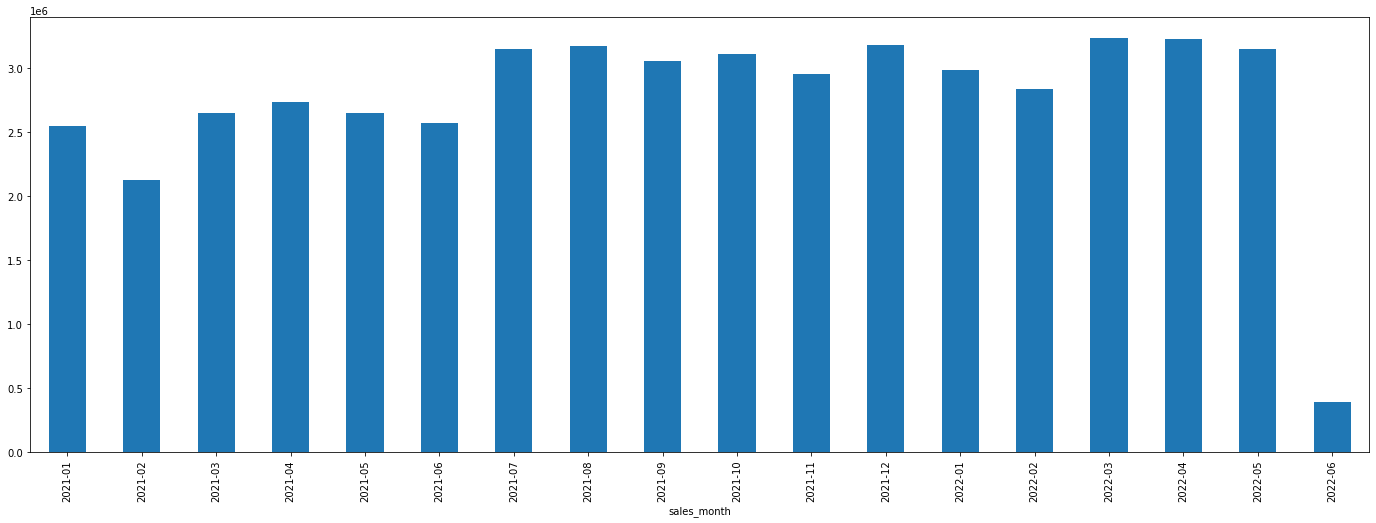

In [33]:
deduped_sales_receipts_with_transactions_dataframe.groupby(['sales_month'])['tx_total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)

## assign locations

In [34]:
#incoming transfer
company_incoming_transfer_packages_dataframe_sj = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000117-LIC']
company_incoming_transfer_packages_dataframe_salinas = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000224-LIC']
company_incoming_transfer_packages_dataframe_uc = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000824-LIC']
#sales & receipt
deduped_sales_receipts_with_transactions_dataframe_sj = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000117-LIC']
deduped_sales_receipts_with_transactions_dataframe_salinas = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000224-LIC']
deduped_sales_receipts_with_transactions_dataframe_uc = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000824-LIC']
#inventory
company_inventory_packages_dataframe_sj = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000117-LIC']
company_inventory_packages_dataframe_salinas = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000224-LIC']
company_inventory_packages_dataframe_uc = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000824-LIC']


# Vendor churn

In [35]:
VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-05-01'
VC_MONTH_LIST = ['2022-02-01','2022-03-01','2022-04-01','2022-05-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [36]:
license_numbers

['C10-0000117-LIC', 'C10-0000224-LIC', 'C10-0000824-LIC']

In [37]:
churn_sj_short,vc_matrix_sj_short = client_surveillance_jupyter.calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe_sj,['C10-0000117-LIC'],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_salinas_short,vc_matrix_salinas_short = client_surveillance_jupyter.calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe_salinas,['C10-0000224-LIC'],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_uc_short,vc_matrix_uc_short = client_surveillance_jupyter.calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe_uc,['C10-0000824-LIC'],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)



In [ ]:
# ax = churn['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC old')
# ax = churn_sj_short['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC short')
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
# ax = plt.title('Rolling 4m vendor churn')
# ax = plt.legend()

# Receiver wholesale price outlier check

In [38]:
per_unit_incoming_package_sort,per_unit_incoming_product_sort = client_surveillance_jupyter.check_per_unit_incoming(company_incoming_transfer_packages_dataframe)


printing per unit incoming by package ID summary ...
max per unit incoming: 600.0 from package ID: 4549814
min per unit incoming: 4e-05 from package ID: 17533208



In [39]:
# top 5
print('Top 5 per unit incoming packages')
per_unit_incoming_package_sort.head(20)

Top 5 per unit incoming packages


,package_id,per_unit_incoming
0,4549814,600.0
1,12085316,200.0
2,14923520,100.0
3,19906543,100.0
4,19688151,100.0
5,19710500,100.0
6,20800350,100.0
7,15011240,100.0
8,11119445,100.0
9,14292034,90.0


In [40]:
print('Bottom 5 per unit incoming packages')
per_unit_incoming_package_sort.dropna().tail(5)


Bottom 5 per unit incoming packages


,package_id,per_unit_incoming
49826,17535570,0.000083
49827,17536142,0.000083
49828,17533230,0.000080
49829,17533219,0.000080
49830,17533208,0.000040


In [41]:
# look at large cost items if any
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] > 10000]

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipment_transaction_type,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type_1,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,receiver_wholesale_price,received_quantity,received_unit_of_measure,item_unit_weight,item_unit_weight_unit_of_measure_name,per_unit_incoming


# COGS analysis

In [42]:
df_in = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] <= 10000]
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

In [43]:
#sj
df_inventory_sj = company_inventory_packages_dataframe_sj
df_sales_sj = deduped_sales_receipts_with_transactions_dataframe_sj
df_summary_simp_sj,_ = client_surveillance_jupyter.cogs_analysis(df_in,df_sales_sj,'monthly',company_state)

df_summary_simp_sj

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm_final,gm_past_quarter_final,gm_past_2quarters_final,gm_past_3quarters_final,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01,2021-01,924035.24,362659.52,561375.72,0.61,32647.0,13385.0,19262,0.86,37866,1062640.53,460577.60,602062.93,0.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.57,NaN,NaN,NaN,NaN
2021-02,2021-02,871998.19,396515.88,475482.31,0.55,34267.0,1422.0,32845,0.98,35142,1002797.92,503575.17,499222.75,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,-0.06
2021-03,2021-03,1015107.36,475520.50,539586.86,0.53,39471.0,692.0,38779,0.99,39955,1167373.46,603911.03,563462.43,0.48,0.56,NaN,NaN,1234695.90,0.52,NaN,NaN,0.48,0.52,NaN,NaN,0.16
2021-04,2021-04,981521.35,453319.35,528202.00,0.54,39355.0,223.0,39132,1.00,39551,1128749.55,575715.58,553033.97,0.49,0.54,NaN,NaN,1325355.73,0.49,NaN,NaN,0.49,0.49,NaN,NaN,-0.03
2021-05,2021-05,966732.84,442892.43,523840.41,0.54,39410.0,90.0,39320,1.00,39553,1111742.77,562473.39,549269.38,0.49,0.54,NaN,NaN,1371732.28,0.49,NaN,NaN,0.49,0.49,NaN,NaN,-0.02
2021-06,2021-06,913050.60,394677.84,518372.76,0.57,38794.0,60.0,38734,1.00,38885,1050008.19,501240.86,548767.33,0.52,0.55,0.56,NaN,1290889.62,0.50,0.51,NaN,0.52,0.50,0.51,NaN,-0.06
2021-07,2021-07,928277.58,396743.69,531533.89,0.57,39753.0,100.0,39653,1.00,39827,1067519.22,503864.49,563654.73,0.53,0.56,0.55,NaN,1234313.96,0.51,0.50,NaN,0.53,0.51,0.50,NaN,0.02
2021-08,2021-08,887935.20,357314.80,530620.40,0.60,38753.0,55.0,38698,1.00,38759,1021125.48,453789.79,567335.69,0.56,0.58,0.56,NaN,1148736.33,0.54,0.51,NaN,0.56,0.54,0.51,NaN,-0.04
2021-09,2021-09,832715.20,338639.74,494075.46,0.59,36392.0,38.0,36354,1.00,36397,957622.48,430072.47,527550.01,0.55,0.59,0.57,0.57,1092698.23,0.54,0.52,0.52,0.55,0.54,0.52,0.52,-0.06


In [44]:
#san
df_inventory_salinas = company_inventory_packages_dataframe_salinas
df_sales_salinas = deduped_sales_receipts_with_transactions_dataframe_salinas
df_summary_simp_salinas,_ = client_surveillance_jupyter.cogs_analysis(df_in,df_sales_salinas,'monthly',company_state)

df_summary_simp_salinas

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm_final,gm_past_quarter_final,gm_past_2quarters_final,gm_past_3quarters_final,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01,2021-01,1621683.70,560930.23,1060753.47,0.65,52301,24117,28184,0.89,58461,1864936.26,712381.39,1152554.87,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.62,NaN,NaN,NaN,NaN
2021-02,2021-02,1252852.00,498087.54,754764.46,0.60,43936,4361,39575,0.96,45739,1440779.80,632571.17,808208.63,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.56,NaN,NaN,NaN,-0.23
2021-03,2021-03,1631096.65,651373.17,979723.48,0.60,57510,2295,55215,0.98,58946,1875761.15,827243.92,1048517.23,0.56,0.62,NaN,NaN,1710390.93,0.58,NaN,NaN,0.56,0.58,NaN,NaN,0.30
2021-04,2021-04,1751142.58,714395.88,1036746.70,0.59,64512,1549,62963,0.99,65177,2013813.97,907282.77,1106531.20,0.55,0.60,NaN,NaN,1863856.59,0.56,NaN,NaN,0.55,0.56,NaN,NaN,0.07
2021-05,2021-05,1682848.54,677762.99,1005085.55,0.60,60097,1105,58992,1.00,60362,1935275.82,860759.00,1074516.82,0.56,0.60,NaN,NaN,2043532.04,0.55,NaN,NaN,0.56,0.55,NaN,NaN,-0.04
2021-06,2021-06,1594367.39,627286.65,967080.74,0.61,55520,729,54791,1.00,55701,1833522.50,796654.05,1036868.45,0.57,0.60,0.61,NaN,2019445.53,0.56,0.57,NaN,0.57,0.56,0.57,NaN,-0.05
2021-07,2021-07,1641964.88,640723.16,1001241.72,0.61,59225,314,58911,1.00,59321,1888259.61,813718.41,1074541.20,0.57,0.60,0.60,NaN,1945772.80,0.56,0.56,NaN,0.57,0.56,0.56,NaN,0.03
2021-08,2021-08,1556422.27,560628.85,995793.42,0.64,56722,120,56602,1.00,56800,1789885.61,711998.64,1077886.97,0.60,0.62,0.61,NaN,1828638.66,0.58,0.57,NaN,0.60,0.58,0.57,NaN,-0.05
2021-09,2021-09,1439677.31,502722.21,936955.10,0.65,53452,91,53361,1.00,53490,1655628.91,638457.21,1017171.69,0.61,0.63,0.62,0.62,1704074.22,0.60,0.58,0.58,0.61,0.60,0.58,0.58,-0.08


In [45]:
#uc
df_inventory_uc = company_inventory_packages_dataframe_uc
df_sales_uc = deduped_sales_receipts_with_transactions_dataframe_uc
df_summary_simp_uc,_ = client_surveillance_jupyter.cogs_analysis(df_in,df_sales_uc,'monthly',company_state)

df_summary_simp_uc


,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm_final,gm_past_quarter_final,gm_past_2quarters_final,gm_past_3quarters_final,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06,2021-06,65444.39,28333.06,37111.33,0.57,3147.0,0.0,3147,1.00,3147,75261.05,35982.99,39278.06,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.52,NaN,NaN,NaN,NaN
2021-07,2021-07,580881.63,230102.65,350778.98,0.60,25258.0,0.0,25258,1.00,25258,668013.87,292230.37,375783.51,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.56,NaN,NaN,NaN,7.88
2021-08,2021-08,731343.58,268732.51,462611.07,0.63,30267.0,0.0,30267,1.00,30267,841045.12,341290.28,499754.83,0.59,0.60,NaN,NaN,527168.22,0.56,NaN,NaN,0.59,0.56,NaN,NaN,0.26
2021-09,2021-09,786411.75,293296.42,493115.33,0.63,32347.0,0.0,32347,1.00,32347,904373.51,372486.45,531887.06,0.59,0.62,NaN,NaN,792131.58,0.58,NaN,NaN,0.59,0.58,NaN,NaN,0.08
2021-10,2021-10,902437.62,354429.96,548007.66,0.61,36595.0,0.0,36595,1.00,36595,1037803.26,450126.05,587677.21,0.57,0.62,NaN,NaN,916458.88,0.58,NaN,NaN,0.57,0.58,NaN,NaN,0.15
2021-11,2021-11,957907.31,379237.17,578670.14,0.60,39304.0,0.0,39304,1.00,39304,1101593.41,481631.20,619962.20,0.56,0.61,0.61,NaN,1026963.54,0.57,0.57,NaN,0.56,0.57,0.57,NaN,0.06
2021-12,2021-12,1114845.58,449266.29,665579.29,0.60,45753.0,0.0,45753,1.00,45753,1282072.42,570568.18,711504.23,0.55,0.60,0.61,NaN,1182933.42,0.56,0.57,NaN,0.55,0.56,0.57,NaN,0.16
2022-01,2022-01,1108256.47,449679.17,658577.30,0.59,46614.0,0.0,46614,1.00,46614,1274494.94,571092.55,703402.39,0.55,0.60,0.61,NaN,1278182.63,0.56,0.57,NaN,0.55,0.56,0.57,NaN,-0.01
2022-02,2022-02,1129887.15,464381.57,665505.58,0.59,46023.0,0.0,46023,1.00,46023,1299370.22,589764.59,709605.63,0.55,0.59,0.60,0.60,1363327.03,0.55,0.56,0.56,0.55,0.55,0.56,0.56,0.02


# Revenue change vs state

In [46]:
#sj
sj_revenue_vs_state = client_surveillance_jupyter.get_gmv_change(company_state,df_summary_simp_sj)
sj_revenue_vs_state
#salinas
salinas_revenue_vs_state = client_surveillance_jupyter.get_gmv_change(company_state,df_summary_simp_salinas)
salinas_revenue_vs_state
#uc
uc_revenue_vs_state = client_surveillance_jupyter.get_gmv_change(company_state,df_summary_simp_uc)
uc_revenue_vs_state


,sum_gmv,sum_gmv_change,sum_gmv_change_ca,weight,variance,points,total
2020Q1,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q2,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q3,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q4,0.00,NaN,0.17,0.04,NaN,10,0.4
2021Q1,0.00,NaN,-0.05,0.28,NaN,10,2.8
2021Q2,65444.39,NaN,0.02,0.52,NaN,10,5.2
2021Q3,2098636.96,31.067484,-0.11,0.76,31.177484,10,7.6
2021Q4,2975190.51,0.417678,0.00,1.00,0.417678,10,10.0


# Inventory

In [47]:
today = date.today()
today

datetime.date(2022, 6, 6)

In [48]:
COMPANY_IDENTIFIER

['GF']

In [49]:
license_numbers

['C10-0000117-LIC', 'C10-0000224-LIC', 'C10-0000824-LIC']

In [50]:
df_inventory_license_sj = client_surveillance_jupyter.calculate_inventory_valuation(df_in,df_inventory_sj,['C10-0000117-LIC'],today)
df_inventory_license_salinas = client_surveillance_jupyter.calculate_inventory_valuation(df_in,df_inventory_salinas,['C10-0000224-LIC'],today)
df_inventory_license_uc = client_surveillance_jupyter.calculate_inventory_valuation(df_in,df_inventory_uc,['C10-0000824-LIC'],today)



In [51]:
df_inventory_license_sj_msrp = client_surveillance_jupyter.calculate_msrp_based_inventory_valuation(df_in,df_sales_sj,df_inventory_sj,['C10-0000117-LIC'],today)
df_inventory_license_salinas_msrp = client_surveillance_jupyter.calculate_msrp_based_inventory_valuation(df_in,df_sales_salinas,df_inventory_salinas,['C10-0000224-LIC'],today)
df_inventory_license_uc_msrp = client_surveillance_jupyter.calculate_msrp_based_inventory_valuation(df_in,df_sales_uc,df_inventory_uc,['C10-0000824-LIC'],today)


In [52]:
df_inventory_license_fresh_sj,_ = client_surveillance_jupyter.calculate_inventory_valuation_fresh(df_in,df_inventory_sj,['C10-0000117-LIC'],today)
df_inventory_license_fresh_salinas,_ = client_surveillance_jupyter.calculate_inventory_valuation_fresh(df_in,df_inventory_salinas,['C10-0000224-LIC'],today)
df_inventory_license_fresh_uc,_ = client_surveillance_jupyter.calculate_inventory_valuation_fresh(df_in,df_inventory_uc,['C10-0000824-LIC'],today)


# Repayment score

In [ ]:
company_repayment_data

In [ ]:
company_repayment_data_due = company_repayment_data[company_repayment_data['adjusted_maturity_date'] < today]

In [ ]:
company_repayment_data_due

In [ ]:
company_repayment_data_due['weight'] = company_repayment_data_due['loan_amount'] / sum(company_repayment_data_due['loan_amount'])

In [ ]:
company_repayment_data_due

In [ ]:
weighted_dpd = sum(company_repayment_data_due['days_late'] * company_repayment_data_due['weight'])
weighted_dpd

In [ ]:
repayment_score = client_surveillance_jupyter.get_short_repayment_score(weighted_dpd)
repayment_score

# Create Template: updated

In [53]:
current_month = '2022-05'
full_score = 45

In [54]:
license_numbers

['C10-0000117-LIC', 'C10-0000224-LIC', 'C10-0000824-LIC']

In [57]:
#sj
template_sj = client_surveillance_jupyter.create_template_update(sj_revenue_vs_state,df_summary_simp_sj,\
                                                               df_inventory_license_sj,\
                                                               df_inventory_license_sj_msrp,\
                                                               df_inventory_license_fresh_sj,\
                                                               churn_sj_short,\
                                                               retial_license_check_df,['C10-0000117-LIC'],\
                                                               company_state,current_month)

#salinas
template_salinas = client_surveillance_jupyter.create_template_update(salinas_revenue_vs_state,df_summary_simp_salinas,\
                                                               df_inventory_license_salinas,\
                                                               df_inventory_license_salinas_msrp,\
                                                               df_inventory_license_fresh_salinas,\
                                                               churn_salinas_short,\
                                                               retial_license_check_df,['C10-0000224-LIC'],\
                                                               company_state,current_month)

#uc
template_uc = client_surveillance_jupyter.create_template_update(uc_revenue_vs_state,df_summary_simp_uc,\
                                                               df_inventory_license_uc,\
                                                               df_inventory_license_uc_msrp,\
                                                               df_inventory_license_fresh_uc,\
                                                               churn_uc_short,\
                                                               retial_license_check_df,['C10-0000824-LIC'],\
                                                               company_state,current_month)

0.9688888888888888 True
0.88 True
14.132173575264517 10
0.0 10
0.9788888888888889 True
0.94 True
11.248244089507446 10
0.010710536574586989 10
0.976923076923077 True
0.94 True
15.489565702588921 10
0.0 10


In [64]:
template_sj

,0,1
0,legal name,"WF ENTERPRISES, INC."
1,date,2022-05
2,license,[C10-0000117-LIC]
3,license is current,True
4,license is active,Active
5,license check,YES
6,metrc cogs coverage,0.97
7,metrc cogs coverage reliable ?,True
8,metrc inventory coverage,0.88
9,metrc inventory coverage reliable ?,True


# Output data 

In [59]:
license_numbers

['C10-0000117-LIC', 'C10-0000224-LIC', 'C10-0000824-LIC']

In [60]:
#sj
license_number = 'C10-0000117-LIC'
COMPANY_IDENTIFIER = 'GF_SJ'
template_sj.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_sj.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_license_sj_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val_msrp.csv')
df_inventory_license_fresh_sj.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_fresh.csv')
df_summary_simp_sj.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_sj_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_sj_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
sj_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [61]:
#salinas
license_number = 'C10-0000224-LIC'
COMPANY_IDENTIFIER = 'GF_SALINAS'
template_salinas.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_salinas.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_license_salinas_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val_msrp.csv')
df_inventory_license_fresh_salinas.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_fresh.csv')
df_summary_simp_salinas.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_salinas_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_salinas_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
salinas_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [62]:
#uc
license_number = 'C10-0000824-LIC'
COMPANY_IDENTIFIER = 'GF_UC'
template_uc.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_uc.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_license_uc_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val_msrp.csv')
df_inventory_license_fresh_uc.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_fresh.csv')
df_summary_simp_uc.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_uc_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_uc_short.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
uc_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')

